# [과제 2] 회귀분석
### - Ch 1, Ch 2를 토대로 자유롭게 회귀분석과 회귀진단을 진행해주세요.
### - 주석으로 설명 및 근거 자세하게 달아주시면 감사하겠습니다. :)

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Data

데이터 출처 : https://www.kaggle.com/avikasliwal/used-cars-price-prediction

< y >
* **Price** : The price of the used car in INR Lakhs.



< X >
* Name : The brand and model of the car
* Location : The location in which the car is being sold or is available for purchase.
* Year : The year or edition of the model.
* Kilometers_Driven : The total kilometres driven in the car by the previous owner(s) in KM.
* Fuel_Type : The type of fuel used by the car. (Petrol, Diesel, Electric, CNG, LPG)
* Transmission : The type of transmission used by the car. (Automatic / Manual)
* Owner_Type : Whether the ownership is Firsthand, Second hand or other.
* Mileage : The standard mileage offered by the car company in kmpl or km/kg
* Engine : The displacement volume of the engine in CC.
* Power : The maximum power of the engine in bhp.
* Seats : The number of seats in the car.
* New_Price : The price of a new car of the same model.

In [3]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/ToBigs/02. Optimization, Regression/Regression/과제/assignment2_data.csv')
df.head()
print(df.shape)

(6019, 14)


Kaggle dataset 확인시 test에 1234 행으로 확인 -> train, test split

In [5]:
# train/test split
train = df.loc[0 : df.shape[0]- 1234]
test = df.loc[df.shape[0]- 1234 : ]
print(train.shape, test.shape)

(4786, 14) (1234, 14)


# EDA

In [6]:
train.isna().sum()

Unnamed: 0              0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 1
Engine                 32
Power                  32
Seats                  37
New_Price            4153
Price                   0
dtype: int64

New_Price 컬럼의 경우 결측치가 많아 train, test에 제거

In [7]:
train_c = train.drop('New_Price', axis = 1)
test_c = test.drop('New_Price', axis = 1)
train_c.columns, test_c.columns # 제거 확인

(Index(['Unnamed: 0', 'Name', 'Location', 'Year', 'Kilometers_Driven',
        'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power',
        'Seats', 'Price'],
       dtype='object'),
 Index(['Unnamed: 0', 'Name', 'Location', 'Year', 'Kilometers_Driven',
        'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power',
        'Seats', 'Price'],
       dtype='object'))

In [8]:
train_c.duplicated().sum() # 중복 없음 확인

0

In [9]:
# 각 수치형 value unique 확인
num_col = train_c.select_dtypes(exclude= object).columns.tolist() # 수치형 column
for each_col in num_col:
  print(f"============ {each_col} =============")
  each_unique = train_c[each_col]
  if train_c[each_col].nunique() < 30:
    print(train_c[each_col].value_counts())
  else:
    print("too many unique values")
    print("total unique num count:", train_c[each_col].nunique())

============ Unnamed: 0 =============
too many unique values
total unique num count: 4786
============ Year =============
2014    641
2016    598
2015    578
2013    511
2017    471
2012    454
2011    377
2010    291
2018    229
2009    156
2008    142
2007     96
2019     76
2006     60
2005     47
2004     24
2003     13
2002     10
2001      5
1998      3
2000      2
1999      2
Name: Year, dtype: int64
============ Kilometers_Driven =============
too many unique values
total unique num count: 2521
============ Seats =============
5.0     3982
7.0      541
8.0      104
4.0       77
6.0       24
2.0       12
10.0       5
9.0        3
0.0        1
Name: Seats, dtype: int64
============ Price =============
too many unique values
total unique num count: 1208


 Unnamed: 0 컬럼 제거

In [10]:
train_c = train_c.drop('Unnamed: 0', axis = 1)
test_c = test_c.drop('Unnamed: 0', axis = 1)
train_c.columns, test_c.columns # 제거 확인

(Index(['Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
        'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
        'Price'],
       dtype='object'),
 Index(['Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
        'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
        'Price'],
       dtype='object'))

In [11]:
# 각 범주형 변수의 value unique 확인
cat_col = train_c.select_dtypes(include= object).columns.tolist() # 범주형 column
for each_col in cat_col:
  print(f"============ {each_col} =============")
  each_unique = train_c[each_col]
  if train_c[each_col].nunique() < 30:
    print(train_c[each_col].value_counts())
  else:
    print("too many unique values")
    print("total categories count:", train_c[each_col].nunique())

============ Name =============
too many unique values
total categories count: 1691
============ Location =============
Mumbai        633
Hyderabad     581
Coimbatore    515
Kochi         509
Pune          495
Delhi         440
Kolkata       432
Chennai       379
Jaipur        333
Bangalore     289
Ahmedabad     180
Name: Location, dtype: int64
============ Fuel_Type =============
Diesel      2539
Petrol      2192
CNG           46
LPG            8
Electric       1
Name: Fuel_Type, dtype: int64
============ Transmission =============
Manual       3400
Automatic    1386
Name: Transmission, dtype: int64
============ Owner_Type =============
First             3929
Second             760
Third               89
Fourth & Above       8
Name: Owner_Type, dtype: int64
============ Mileage =============
too many unique values
total categories count: 427
============ Engine =============
too many unique values
total categories count: 138
============ Power =============
too many unique values
tota

In [12]:
train_c['Engine'].unique()
train_c['Power'].unique()
train_c['Mileage'].unique()

array(['26.6 km/kg', '19.67 kmpl', '18.2 kmpl', '20.77 kmpl', '15.2 kmpl',
       '21.1 km/kg', '23.08 kmpl', '11.36 kmpl', '20.54 kmpl',
       '22.3 kmpl', '21.56 kmpl', '16.8 kmpl', '25.2 kmpl', '12.7 kmpl',
       '0.0 kmpl', '13.5 kmpl', '25.8 kmpl', '28.4 kmpl', '20.45 kmpl',
       '14.84 kmpl', '22.69 kmpl', '23.65 kmpl', '13.53 kmpl',
       '18.5 kmpl', '14.4 kmpl', '20.92 kmpl', '17.5 kmpl', '12.8 kmpl',
       '19.01 kmpl', '14.53 kmpl', '11.18 kmpl', '12.4 kmpl',
       '16.09 kmpl', '14.0 kmpl', '24.3 kmpl', '18.15 kmpl', '11.74 kmpl',
       '22.07 kmpl', '19.7 kmpl', '25.4 kmpl', '25.32 kmpl', '14.62 kmpl',
       '14.28 kmpl', '14.9 kmpl', '11.25 kmpl', '24.4 kmpl', '16.55 kmpl',
       '17.11 kmpl', '22.9 kmpl', '17.8 kmpl', '18.9 kmpl', '15.04 kmpl',
       '25.17 kmpl', '20.36 kmpl', '13.29 kmpl', '13.68 kmpl',
       '20.0 kmpl', '15.8 kmpl', '25.0 kmpl', '16.4 kmpl', '24.52 kmpl',
       '22.1 kmpl', '8.5 kmpl', '15.1 kmpl', '16.95 kmpl', '19.64 kmpl',
       '16.

'km/kg'와 'kmpl' 단위의 차이가 있다. 둘은 연비를 뜻하므로, 단위 제거 후 수치형으로 변환

이외 Power & Engine도 단위 제거 후 수치형 변환

In [13]:
print("Before NA drop:", train_c.shape)
train_c = train_c.dropna() # 결측치 제거
print("After NA drop:", train_c.shape)

Before NA drop: (4786, 12)
After NA drop: (4748, 12)


In [14]:
# train, test 똑같이 적용
def numerical(df, col_list):
  for column in col_list:
    df[column] = df[column].str.replace('null', '0')
    df[column] = df[column].str.split().str[0].astype(float)
  return df
col_list = ['Mileage', 'Power', 'Engine']
train_c = numerical(train_c, col_list)
test_c = numerical(test_c, col_list)
train_c.info(), test_c.info() # 확인

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4748 entries, 0 to 4785
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               4748 non-null   object 
 1   Location           4748 non-null   object 
 2   Year               4748 non-null   int64  
 3   Kilometers_Driven  4748 non-null   int64  
 4   Fuel_Type          4748 non-null   object 
 5   Transmission       4748 non-null   object 
 6   Owner_Type         4748 non-null   object 
 7   Mileage            4748 non-null   float64
 8   Engine             4748 non-null   float64
 9   Power              4748 non-null   float64
 10  Seats              4748 non-null   float64
 11  Price              4748 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 482.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 4785 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  

(None, None)

Distribution Plot 확인

In [15]:
train_c.select_dtypes(exclude= object).columns.tolist()

['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Price']

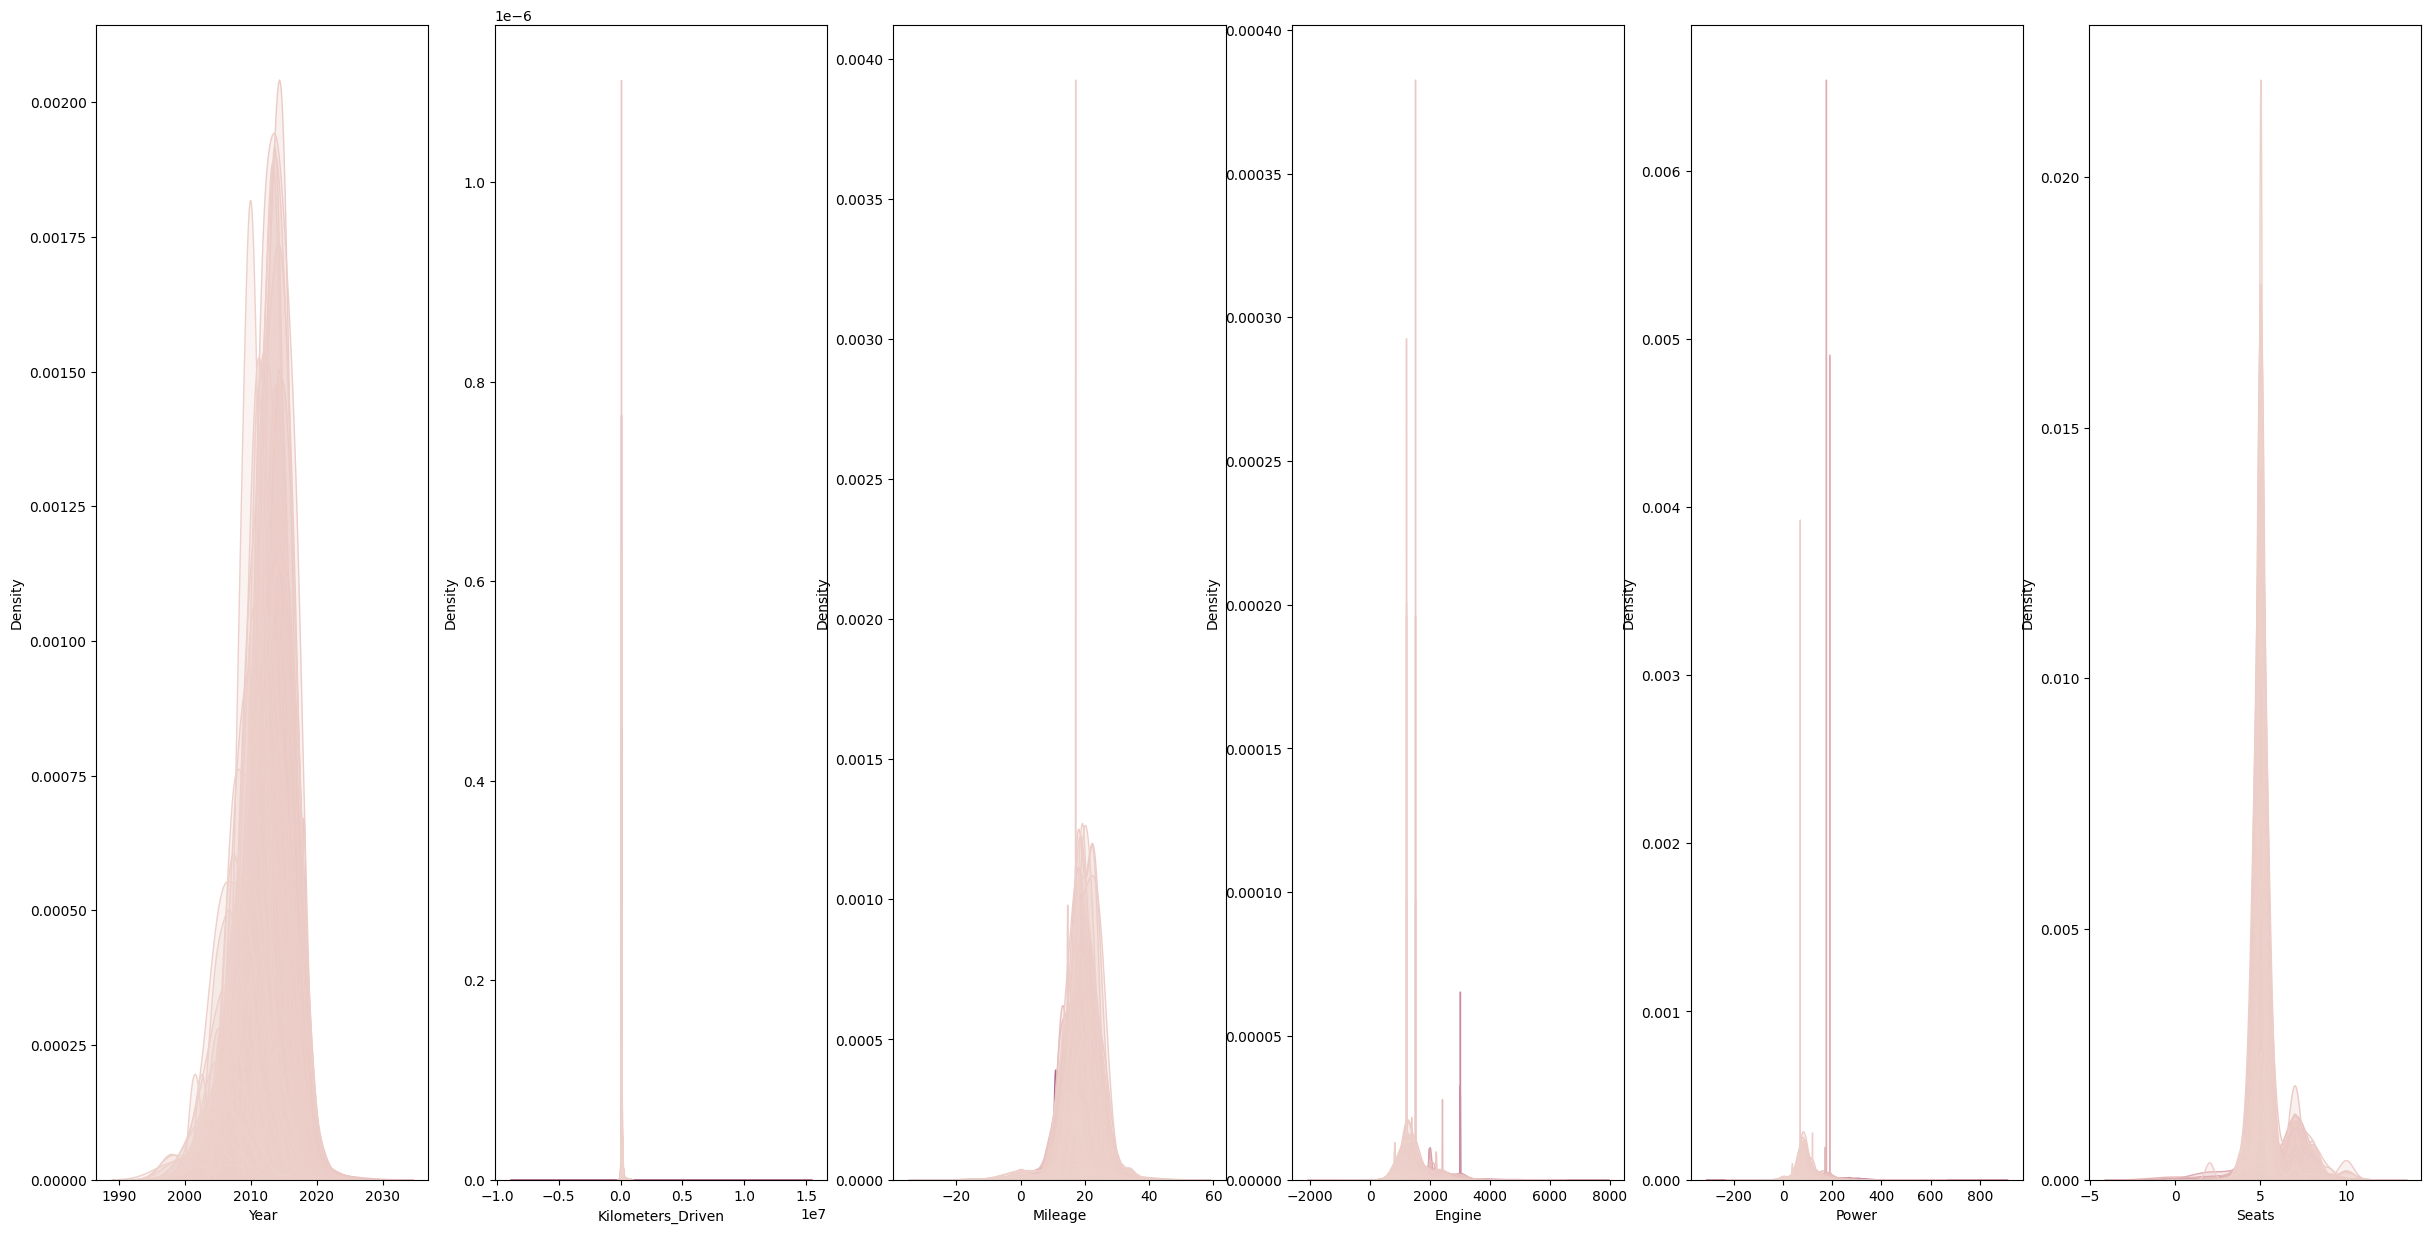

In [16]:
fig, ax = plt.subplots(1, 6, figsize = (30, 15))
for i, col in enumerate(train_c.select_dtypes(exclude= object).columns.tolist()):
    if col == 'Price':
      continue
    else:
      sns.kdeplot(data = train_c, x = col, fill = True, ax = ax[i % 6], hue = train_c['Price'], legend = False )

In [17]:
# 수치형 : minmaxscaling
print("Before scaling : \n", train_c.describe())
num_list = train_c.select_dtypes(exclude= object).columns.tolist()
num_list.remove('Price')

mm = MinMaxScaler()
train_c[num_list] = mm.fit_transform(train_c[num_list])
test_c[num_list] = mm.transform(test_c[num_list])
print("After scaling : \n", train_c.describe())

Before scaling : 
               Year  Kilometers_Driven      Mileage       Engine        Power  \
count  4748.000000       4.748000e+03  4748.000000  4748.000000  4748.000000   
mean   2013.379107       5.906290e+04    18.136535  1621.314448   111.308350   
std       3.220812       1.012270e+05     4.488385   594.815216    54.673308   
min    1998.000000       1.710000e+02     0.000000   624.000000     0.000000   
25%    2011.000000       3.400000e+04    15.100000  1198.000000    74.000000   
50%    2014.000000       5.300050e+04    18.150000  1493.000000    92.700000   
75%    2016.000000       7.300000e+04    21.100000  1984.000000   138.100000   
max    2019.000000       6.500000e+06    33.540000  5461.000000   550.000000   

             Seats        Price  
count  4748.000000  4748.000000  
mean      5.281592     9.494930  
std       0.812078    11.148347  
min       0.000000     0.440000  
25%       5.000000     3.500000  
50%       5.000000     5.650000  
75%       5.000000    

In [18]:
cat_col = train_c.select_dtypes(include=object).columns.tolist()
cat_col.remove('Name')

for each_col in cat_col: # test 데이터에 새로운 value가 있을 경우 'other'로 분류
    train_unique = set(train_c[each_col].unique())
    test_unique = set(test_c[each_col].unique())
    all_unique = train_unique.union(test_unique).union({'Other'})

    category_mapping = {category: category if category in train_unique else 'Other' for category in all_unique}

    train_c[each_col] = train_c[each_col].map(category_mapping)
    test_c[each_col] = test_c[each_col].map(category_mapping)

    label = LabelEncoder()
    # Fit the encoder on all unique values including 'Other'
    label.fit(list(all_unique))

    train_c[each_col] = label.transform(train_c[each_col])
    test_c[each_col] = label.transform(test_c[each_col])

# Modeling

In [19]:
import statsmodels.api as sm
X = sm.add_constant(train_c.drop(['Price', 'Name'], axis=1))
model = sm.OLS(train_c['Price'], X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     971.3
Date:                Mon, 29 Jan 2024   Prob (F-statistic):               0.00
Time:                        08:16:20   Log-Likelihood:                -15538.
No. Observations:                4748   AIC:                         3.110e+04
Df Residuals:                    4737   BIC:                         3.117e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.4370      1.26

## Checking Assumptions

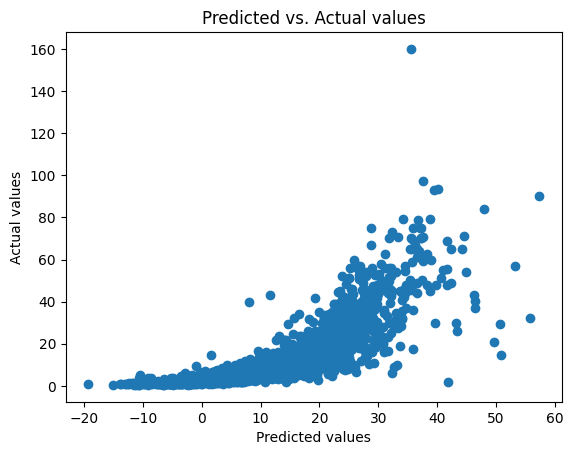

In [21]:
import scipy.stats as stats

predictions = results.predict(X) # y_pred
residuals = train_c['Price'] - predictions # resid

# 1. 선형성 검사
plt.scatter(predictions, train_c['Price'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted vs. Actual values')
plt.show()

### 1. Linearity assumption

In [26]:
train_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4748 entries, 0 to 4785
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               4748 non-null   object 
 1   Location           4748 non-null   int64  
 2   Year               4748 non-null   float64
 3   Kilometers_Driven  4748 non-null   float64
 4   Fuel_Type          4748 non-null   int64  
 5   Transmission       4748 non-null   int64  
 6   Owner_Type         4748 non-null   int64  
 7   Mileage            4748 non-null   float64
 8   Engine             4748 non-null   float64
 9   Power              4748 non-null   float64
 10  Seats              4748 non-null   float64
 11  Price              4748 non-null   float64
dtypes: float64(7), int64(4), object(1)
memory usage: 482.2+ KB


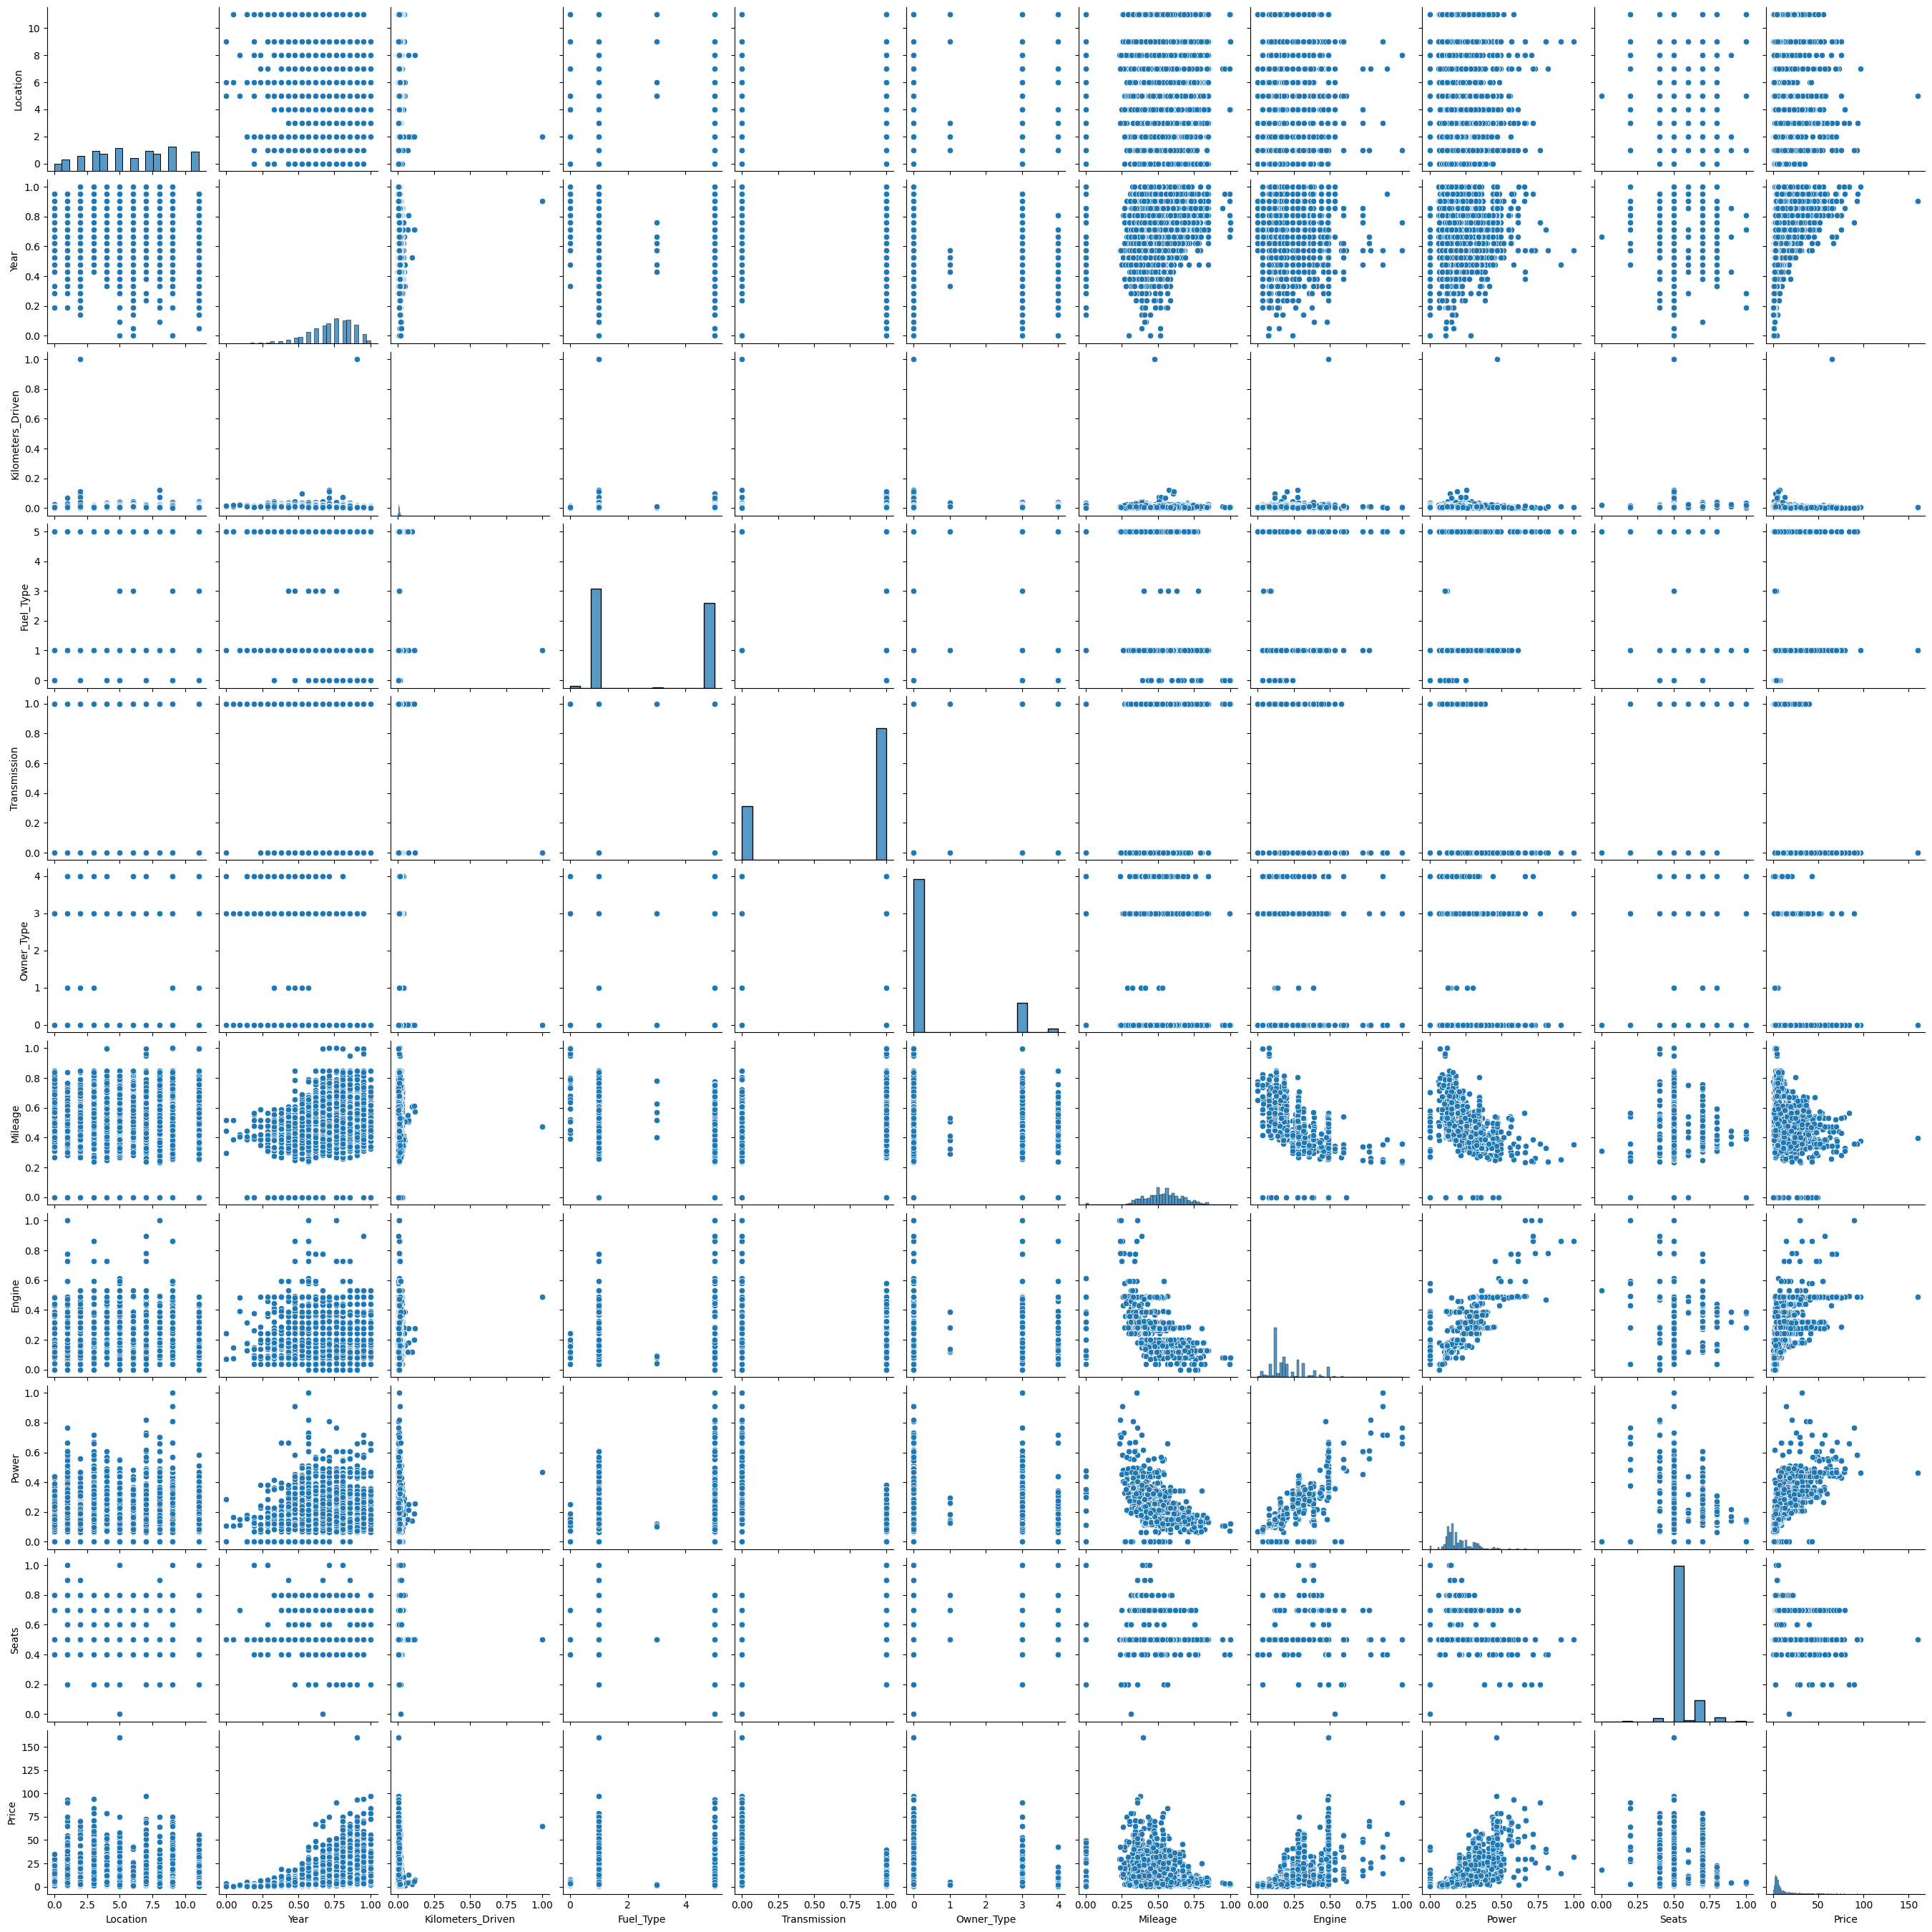

In [23]:
num_col = train_c.select_dtypes(exclude=object).columns.tolist()
p = sns.pairplot(train_c[num_col])

설명변수 Year, Milege, Engine, Power는 종속변수 Price와 선형성을 보여준다.

### 2. Normailtiy Assumption

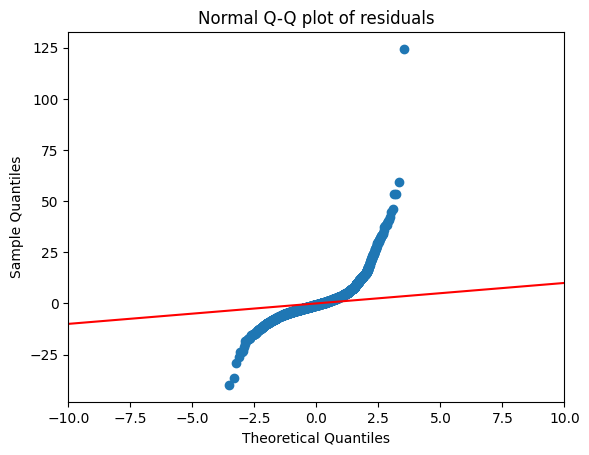

In [31]:
residuals = results.resid

fig = sm.qqplot(residuals, line ='45')
plt.title('Normal Q-Q plot of residuals')
plt.xlim(-10, 10)
plt.show()


잔차는 정규성을 따르지 않는다.

### 3. Homoscadescity Assumption

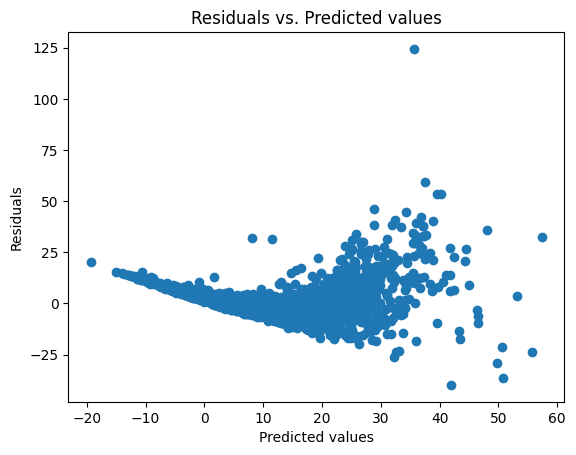

In [32]:
# 3. Homoscedasticity
plt.scatter(predictions, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted values')
plt.show()

잔차는 이분산성을 갖는다.

### 4. Indepedence Assumption

In [34]:
from statsmodels.stats.stattools import durbin_watson

# Calculate the Durbin-Watson statistic
dw_statistic = durbin_watson(residuals)

print("Durbin-Watson Statistic:", dw_statistic)

Durbin-Watson Statistic: 1.9898564715715747


Durbin-Watson 값이 2에 가까우므로 자기상관성이 없다.